<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [ ]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip /content/drive/'My Drive'/'MADE CV'/handout.zip 

Archive:  /content/drive/My Drive/MADE CV/handout.zip
   creating: handout/
   creating: handout/data/
  inflating: handout/data/captions_tokenized.json  
  inflating: handout/data/image_codes.npy  


In [4]:
!mv ./handout/data ./data 

### Data preprocessing

In [5]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 167 ms, sys: 499 ms, total: 665 ms
Wall time: 674 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [6]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [7]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [8]:
# Build a Vocabulary
from collections import Counter
import tqdm

word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for image in tqdm.tqdm(captions):
    for caption in image:
        word_counts += Counter(caption)

100%|██████████| 118287/118287 [13:48<00:00, 142.71it/s]


In [9]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [10]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [11]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [13]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=512, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, num_layers=2, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (torch.cat((initial_hid[None], initial_hid[None]), dim=0),
                                               torch.cat((initial_cell[None], initial_cell[None]), dim=0)))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [14]:
network = CaptionNet(n_tokens)

In [15]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [16]:
from torch.autograd import Variable

def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data.cpu() if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

In [17]:
# criterion = nn.CrossEntropyLoss(ignore_index = pad_ix)

def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    # log_probs = F.log_softmax(logits_for_next, dim=-1)
    
    # crossentropy = - torch.sum(log_probs * to_one_hot(captions_ix_next, n_tokens).cuda(), dim = -1)

    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    log_probs = F.log_softmax(logits_for_next, dim=-1)
    crossentropy = - torch.sum(log_probs * to_one_hot(captions_ix_next, n_tokens), dim = -1)
    
    mask = (captions_ix_next != pad_ix).type(torch.FloatTensor)
    loss = torch.sum(crossentropy * mask) / torch.sum(mask)
    
    return loss

In [18]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [19]:
opt = torch.optim.Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=6, verbose=True)

# Training

* First implement the batch generator
* Than train the network as usual

In [20]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [21]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [22]:
generate_batch(img_codes,captions,3)

(tensor([[0.2067, 0.3295, 0.0947,  ..., 0.3663, 0.4827, 0.7564],
         [0.0665, 0.5133, 0.2524,  ..., 0.4665, 0.6767, 0.0589],
         [0.1881, 0.1650, 0.2673,  ..., 0.0428, 0.7187, 0.8485]]),
 tensor([[   1,   24,  662,   63,  136, 4816,   35,  319,  331,   15, 3493,   35,
            45,  109,   12,    2],
         [   1,   24,  447,   58,   24,   47, 2845,  448,   35,   24,  184,  793,
            12,    2,    3,    3],
         [   1,   88, 2065,   15,   24, 1122,  211,  624,  117, 2025,   31,   24,
           452,   12,    2,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [23]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [24]:
from tqdm import tqdm

best_loss = None
for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    if best_loss is None or best_loss > val_loss:
        best_loss = val_loss
        torch.save(network.state_dict(), 'network.pt')
    scheduler.step(val_loss)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 6.009409561157226, val loss: 5.010014915466309


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 4.904325008392334, val loss: 4.711811542510986


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.600806035995483, val loss: 4.338218116760254


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.3860543346405025, val loss: 4.237627696990967


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.1707736587524415, val loss: 4.066573810577393


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 4.041981048583985, val loss: 3.984553861618042


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.9034341955184937, val loss: 3.8735257625579833


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.869385042190552, val loss: 3.747872018814087


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.6993851613998414, val loss: 3.6272381782531737


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 3.717466640472412, val loss: 3.667488718032837


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 3.579746975898743, val loss: 3.5411136627197264


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.5070810222625735, val loss: 3.5605936527252195


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.483766584396362, val loss: 3.3963964939117433


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.4166497945785523, val loss: 3.493347692489624


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.383432846069336, val loss: 3.3267605781555174


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.3507357120513914, val loss: 3.3529287338256837


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.2466199016571045, val loss: 3.2252955436706543


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.272664017677307, val loss: 3.222796821594238


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.212483534812927, val loss: 3.2851611137390138


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.2029759216308595, val loss: 3.242945337295532


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.1567665576934814, val loss: 3.1047484397888185


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 3.1764685583114622, val loss: 3.2037899494171143


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 3.141597967147827, val loss: 3.164812183380127


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 3.143272123336792, val loss: 3.171508312225342


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 3.104703469276428, val loss: 3.032150888442993


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 3.0491868925094603, val loss: 3.147998046875


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 3.0603521728515624, val loss: 3.089870262145996


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 3.0298173093795775, val loss: 3.0025641441345217


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 3.0241684103012085, val loss: 3.1119574069976808


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 2.9871483135223387, val loss: 3.1163692474365234


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 2.987314076423645, val loss: 3.015480709075928


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 2.9714627075195312, val loss: 2.9459768772125243


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 2.97332706451416, val loss: 2.95787672996521


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 2.958814163208008, val loss: 3.05981650352478


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 2.9513167047500612, val loss: 2.9850425720214844


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 2.942927556037903, val loss: 2.9518805503845216


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 2.9412051677703857, val loss: 3.0309486389160156


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 2.8923157835006714, val loss: 2.9112361907958983


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 2.946269235610962, val loss: 3.028467798233032


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 2.949277596473694, val loss: 3.087894105911255


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 2.8679470682144164, val loss: 2.9073787689208985


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 2.8413413333892823, val loss: 2.8881513118743896


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 2.8700272941589358, val loss: 2.9417223930358887


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 2.8462983131408692, val loss: 2.926015043258667


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 2.867302141189575, val loss: 2.904157876968384


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 2.8665709114074707, val loss: 2.993218517303467


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 2.83524302482605, val loss: 2.870146322250366


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 2.820365538597107, val loss: 2.7849849224090577


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 2.8119781398773194, val loss: 2.773451566696167


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 2.818100371360779, val loss: 2.777553844451904


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 2.7780428886413575, val loss: 2.7840599060058593


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 2.8082844257354735, val loss: 2.9198137283325196


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 2.760985436439514, val loss: 2.753452205657959


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 2.80471510887146, val loss: 2.8778407096862795


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.7819589281082155, val loss: 2.914985418319702


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 2.7860533571243287, val loss: 2.792717790603638


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 2.7815084743499754, val loss: 2.8837733268737793


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 2.736858744621277, val loss: 2.685958003997803


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.722246928215027, val loss: 2.830307674407959


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 2.759757752418518, val loss: 2.7006131649017333


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.7950511980056763, val loss: 2.881736326217651


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.752119026184082, val loss: 2.815057611465454


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.7349941682815553, val loss: 2.734539031982422


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.7290283155441286, val loss: 2.718500185012817


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch    65: reducing learning rate of group 0 to 5.0000e-04.

Epoch: 64, train loss: 2.7388891410827636, val loss: 2.7750923156738283


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.680722165107727, val loss: 2.6748183727264405


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.659046759605408, val loss: 2.6765061378479005


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.6951593065261843, val loss: 2.579257297515869


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.6885871744155883, val loss: 2.6835384368896484


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 2.687357940673828, val loss: 2.731750249862671


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.6620559549331664, val loss: 2.55910439491272


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.6549838161468506, val loss: 2.6842929840087892


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.6517289161682127, val loss: 2.777913761138916


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.6596269702911375, val loss: 2.5851720333099366


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.6663833618164063, val loss: 2.754658079147339


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.7037036514282224, val loss: 2.7261978149414063


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.670122675895691, val loss: 2.7115324974060058


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch    78: reducing learning rate of group 0 to 2.5000e-04.

Epoch: 77, train loss: 2.6156421375274657, val loss: 2.6442102909088137


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.6441096544265745, val loss: 2.660476636886597


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 2.6794153547286985, val loss: 2.686946964263916


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.6462418746948244, val loss: 2.748829984664917


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.66096426486969, val loss: 2.647929573059082


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.6674397563934327, val loss: 2.694488763809204


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.6638436555862426, val loss: 2.7290576934814452


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch    85: reducing learning rate of group 0 to 1.2500e-04.

Epoch: 84, train loss: 2.6175645923614503, val loss: 2.6272602558135985


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.6356206703186036, val loss: 2.771090793609619


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.644338245391846, val loss: 2.6362772464752195


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.622307147979736, val loss: 2.579518270492554


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.630112042427063, val loss: 2.6871411323547365


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 2.6248988342285156, val loss: 2.6101236820220945


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.628732166290283, val loss: 2.581423807144165


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch    92: reducing learning rate of group 0 to 6.2500e-05.

Epoch: 91, train loss: 2.6321842765808103, val loss: 2.6501187324523925


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.6370747900009155, val loss: 2.5864087104797364


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.6358435773849487, val loss: 2.617864561080933


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.6081717109680174, val loss: 2.6718953132629393


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.6354298877716062, val loss: 2.7309256553649903


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.6178859090805053, val loss: 2.6408435344696044


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.6026060819625854, val loss: 2.6174856185913087


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch    99: reducing learning rate of group 0 to 3.1250e-05.

Epoch: 98, train loss: 2.625632600784302, val loss: 2.6470694065093996


100%|██████████| 50/50 [00:40<00:00,  1.24it/s]



Epoch: 99, train loss: 2.6360576963424682, val loss: 2.7907440662384033
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [27]:
network = CaptionNet(n_tokens)
network.load_state_dict(torch.load('network.pt'))

<All keys matched successfully>

In [30]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [31]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [32]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2020-07-05 20:06:09--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.76.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.76.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2020-07-05 20:06:09--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.02s   

2020-07-05 20:06:09 (2.51 MB/s) - ‘data/img.jpg’ saved [54731/54731]


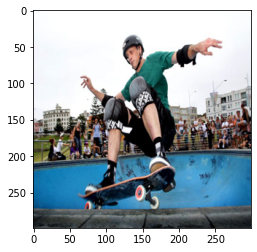

In [33]:
plt.imshow(img)

In [34]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard down a ramp .
a man in a black shirt doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a man doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man is doing a trick on a skateboard .


--2020-07-05 20:06:16--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2020-07-05 20:06:16--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104.37K  --.-KB/s    in 0.08s   

2020-07-05 20:06:16 (1.35 MB/s) - ‘data/img.jpg’ saved [106870/106870]



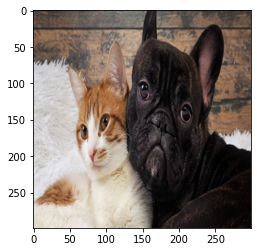

a cat is laying down on a couch .
a cat sitting on top of a wooden table .
a cat is sitting on a couch with a cat .
a cat is laying on the ground with a cat .
a cat is laying on the ground next to a cat .
a cat laying on top of a wooden table .
a cat sitting on top of a wooden table .
a cat is sitting on a bed next to a cat .
a cat sitting on top of a wooden table .
a cat is sitting on the ground with a cat .


In [35]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

--2020-07-05 20:06:21--  https://img.championat.com/s/735x490/news/big/r/z/begovye-trenirovki-i-futbol-gde-svjaz_15320151971740261712.jpg
Resolving img.championat.com (img.championat.com)... 81.19.86.2, 81.19.86.1, 81.19.86.5, ...
Connecting to img.championat.com (img.championat.com)|81.19.86.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112169 (110K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 109.54K   384KB/s    in 0.3s    

2020-07-05 20:06:23 (384 KB/s) - ‘data/img.jpg’ saved [112169/112169]



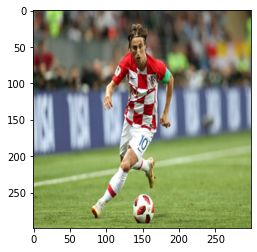

a man in a field playing frisbee in a field .
a man in a blue shirt and a white frisbee in a field .
a man in a field playing frisbee .
a man in a baseball uniform holding a bat .
a young boy is playing frisbee in the grass .
a man in a blue shirt and a frisbee in a field .
a man in a green shirt and a frisbee in the grass .
a man in a blue shirt and a frisbee in a field .
a man in a black shirt is playing frisbee .
a man in a black shirt and white shirt playing frisbee .
--2020-07-05 20:06:28--  https://cdn1.ozone.ru/s3/cms/b8/t09/wc450/912x600_desktop_navigare_m.jpg
Resolving cdn1.ozone.ru (cdn1.ozone.ru)... 93.93.88.163, 93.93.91.60
Connecting to cdn1.ozone.ru (cdn1.ozone.ru)|93.93.88.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45988 (45K) [image/webp]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  44.91K  --.-KB/s    in 0.02s   

2020-07-05 20:06:29 (2.67 MB/s) - ‘data/img.jpg’ saved [45988/45988]



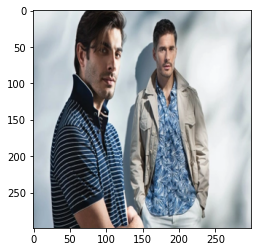

a man wearing a suit and tie with a tie .
a man and woman in a suit and tie .
a man in a suit and tie holding a cell phone .
a man and woman are standing in front of a man .
a man in a suit and tie with a tie .
a man and woman are standing in a room with a man in the background .
a man in a suit and tie wearing a tie .
a man and woman are standing in front of a man in a suit and tie .
a man in a suit and tie in a suit and tie .
a man is standing in front of a man holding a cell phone .
--2020-07-05 20:06:34--  https://cdn1.ozone.ru/s3/cms/ae/t89/wc450/912x600_desktop_delsey_m.jpg
Resolving cdn1.ozone.ru (cdn1.ozone.ru)... 93.93.88.163, 93.93.91.60
Connecting to cdn1.ozone.ru (cdn1.ozone.ru)|93.93.88.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47166 (46K) [image/webp]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  46.06K  --.-KB/s    in 0.02s   

2020-07-05 20:06:35 (2.91 MB/s) - ‘data/img.jpg’ saved [47166/47166]



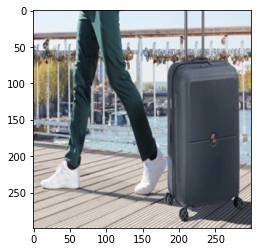

a man is standing in the middle of a street .
a man sitting on a bench in front of a building .
a man in a suit and tie is standing in front of a building .
a man sitting on a bench with a dog in the background .
a man in a suit and tie in a suit and a black tie .
a man is sitting on a bench with a dog in the background .
a man is standing in the middle of a street .
a man in a suit and tie with a black and white cat .
a man is standing in front of a black and white photo of a man .
a man is standing in front of a man in a suit and tie .
--2020-07-05 20:06:41--  https://miro.medium.com/max/11796/1*IC7_pdLtDMqwoqLkTib4JQ.jpeg
Resolving miro.medium.com (miro.medium.com)... 104.16.121.145, 104.16.119.145, 104.16.120.145, ...
Connecting to miro.medium.com (miro.medium.com)|104.16.121.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2959249 (2.8M) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]   2.82M  --.-KB/s    in 0.07s

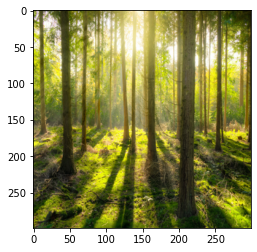

a large group of people on a bench in the water .
a person is walking down a road with a large dog .
a large train is on the side of a river .
a large white train is on the side of a road .
a person is sitting on a bench near a tree .
a person is standing on a large body of water .
a large white and white photo of a train .
a large green and white photo of a train on a track .
a large white and white train on a track .
a large train is sitting on the side of the road .
--2020-07-05 20:06:47--  https://media-cdn.tripadvisor.com/media/photo-s/19/9e/c0/32/random-restaurant.jpg
Resolving media-cdn.tripadvisor.com (media-cdn.tripadvisor.com)... 151.101.2.38, 151.101.66.38, 151.101.130.38, ...
Connecting to media-cdn.tripadvisor.com (media-cdn.tripadvisor.com)|151.101.2.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54671 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.39K  --.-KB/s    in 0.02s   

2020-07-05 20:0

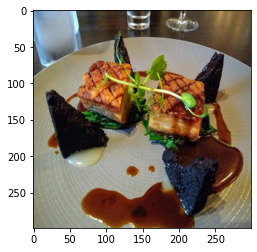

a plate with a plate of food and a plate of food .
a plate with a plate of food and a cup of coffee .
a plate of food with a plate of food and a cup of coffee .
a plate with a plate of food and a plate of food .
a plate with a sandwich and a plate of food .
a plate of food with a plate of food and a cup of coffee .
a plate of food with a plate of food and a cup of coffee .
a plate with a sandwich and a plate of food
a plate of food with a bowl of soup and a cup of coffee .
a plate of food with a sandwich and a cup of coffee .
--2020-07-05 20:06:53--  https://cdn.thedailymash.co.uk/wp-content/uploads/20190324205638/random667.jpg
Resolving cdn.thedailymash.co.uk (cdn.thedailymash.co.uk)... 104.22.41.185, 172.67.12.96, 104.22.40.185, ...
Connecting to cdn.thedailymash.co.uk (cdn.thedailymash.co.uk)|104.22.41.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175554 (171K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 171.

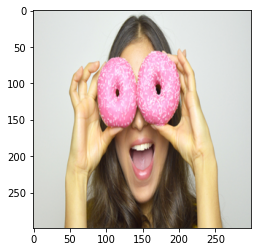

a woman holding a banana in a basket .
a close up of a person holding a banana .
a woman is holding a large piece of water .
a close up of a person holding a banana
a man holding a large piece of cake .
a person holding a banana in a blue and white shirt .
a man is holding a large donut in the water .
a woman holding a banana and a knife .
a man is holding a piece of food .
a couple of people are sitting on a table .
--2020-07-05 20:07:02--  https://helpx.adobe.com/content/dam/help/en/stock/how-to/visual-reverse-image-search/jcr_content/main-pars/image/visual-reverse-image-search-v2_intro.jpg
Resolving helpx.adobe.com (helpx.adobe.com)... 23.199.253.51, 2600:1407:d800:192::1efd, 2600:1407:d800:19a::1efd
Connecting to helpx.adobe.com (helpx.adobe.com)|23.199.253.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224662 (219K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 219.40K  --.-KB/s    in 0.05s   

2020-07-05 20:07

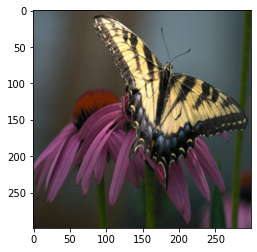

a man is standing in the middle of a room .
a close up of a bird on a table
a white bird sitting on top of a table .
a bird sitting in a vase with a bird on it .
a large bird sitting on top of a wooden table .
a man is standing in a small room with a bird .
a small bird sitting on top of a wooden table .
a couple of birds sitting on top of a wooden table .
a bird sitting on top of a table with a glass of flowers .
a bird sitting on top of a wooden table .
--2020-07-05 20:07:07--  https://www.mangelsen.com/media/wysiwyg/Tiles_CollectorFavs/Tile_SpecialOfferImages2598.jpg
Resolving www.mangelsen.com (www.mangelsen.com)... 209.126.24.128
Connecting to www.mangelsen.com (www.mangelsen.com)|209.126.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162870 (159K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 159.05K  --.-KB/s    in 0.05s   

2020-07-05 20:07:07 (3.07 MB/s) - ‘data/img.jpg’ saved [162870/162870]



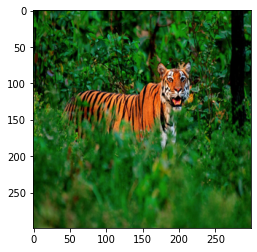

a giraffe standing in a field with trees in the background .
a close up of a zebra in a field
a giraffe standing next to a tree in a field .
a giraffe standing in a field with a tree .
a giraffe standing in a field with a tree .
a zebra standing on a green field .
a zebra is standing in the grass with a tree .
a zebra standing in a field with trees in the background .
a zebra standing next to a tree in a field .
a zebra standing next to a tree in a field .
--2020-07-05 20:07:12--  https://i.pinimg.com/originals/fc/aa/8b/fcaa8be3dc71f9e171ec825f8391a328.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.39.40.217, 2a04:4e42:53::84
Connecting to i.pinimg.com (i.pinimg.com)|23.39.40.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88314 (86K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  86.24K  --.-KB/s    in 0.02s   

2020-07-05 20:07:13 (3.95 MB/s) - ‘data/img.jpg’ saved [88314/88314]



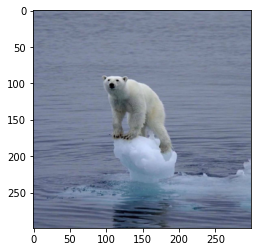

a polar bear is laying on a rock .
a polar bear is laying on a white bed .
a polar bear is laying on a rock .
a polar bear is laying on a rock .
a polar bear is laying on a rock .
a polar bear is laying on a white blanket .
a polar bear is laying on a rock .
a polar bear is laying on a rock .
a polar bear is laying on a bed .
a polar bear is laying on a rock .
--2020-07-05 20:07:18--  https://c.ndtvimg.com/2019-07/l6abj9s_renault-duster-facelift-variants-explained_625x300_10_July_19.jpg
Resolving c.ndtvimg.com (c.ndtvimg.com)... 23.35.200.153, 2600:1407:d800:19d::24e8, 2600:1407:d800:18f::24e8
Connecting to c.ndtvimg.com (c.ndtvimg.com)|23.35.200.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69244 (68K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  67.62K   341KB/s    in 0.2s    

2020-07-05 20:07:19 (341 KB/s) - ‘data/img.jpg’ saved [69244/69244]



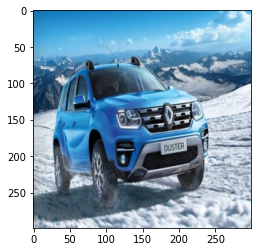

a car parked in a parking lot next to a car .
a car parked next to a car with a red and white car .
a truck with a car and a red car and a red and white and white car .
a car parked in front of a parking meter .
a car with a red and white car parked next to a parking meter .
a car parked in a parking lot with a lot of people .
a car that is parked in a parking lot .
a car parked next to a car on a street .
a car is parked in a parking lot .
a car parked in front of a car with a large car .


In [36]:
# apply your network on images you've found
# Футбол: https://img.championat.com/s/735x490/news/big/r/z/begovye-trenirovki-i-futbol-gde-svjaz_15320151971740261712.jpg
# Реклама одежды: https://cdn1.ozone.ru/s3/cms/b8/t09/wc450/912x600_desktop_navigare_m.jpg
# Чемодан: https://cdn1.ozone.ru/s3/cms/ae/t89/wc450/912x600_desktop_delsey_m.jpg
# Лес: https://miro.medium.com/max/11796/1*IC7_pdLtDMqwoqLkTib4JQ.jpeg
# Блюдо: https://media-cdn.tripadvisor.com/media/photo-s/19/9e/c0/32/random-restaurant.jpg
# Девушка с пончиками: https://cdn.thedailymash.co.uk/wp-content/uploads/20190324205638/random667.jpg
# Бабочка на цветочке: https://helpx.adobe.com/content/dam/help/en/stock/how-to/visual-reverse-image-search/jcr_content/main-pars/image/visual-reverse-image-search-v2_intro.jpg
# Тигр в кустах: https://www.mangelsen.com/media/wysiwyg/Tiles_CollectorFavs/Tile_SpecialOfferImages2598.jpg
# Полярный медведь: https://i.pinimg.com/originals/fc/aa/8b/fcaa8be3dc71f9e171ec825f8391a328.jpg
# Автомобиль в снежных горах: https://c.ndtvimg.com/2019-07/l6abj9s_renault-duster-facelift-variants-explained_625x300_10_July_19.jpg

def generate_caption_for_img(img_url):
    !wget $img_url -O data/img.jpg
    img = plt.imread('data/img.jpg')
    img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))


image_urls = [
    'https://img.championat.com/s/735x490/news/big/r/z/begovye-trenirovki-i-futbol-gde-svjaz_15320151971740261712.jpg',
    'https://cdn1.ozone.ru/s3/cms/b8/t09/wc450/912x600_desktop_navigare_m.jpg',
    'https://cdn1.ozone.ru/s3/cms/ae/t89/wc450/912x600_desktop_delsey_m.jpg',
    'https://miro.medium.com/max/11796/1*IC7_pdLtDMqwoqLkTib4JQ.jpeg',
    'https://media-cdn.tripadvisor.com/media/photo-s/19/9e/c0/32/random-restaurant.jpg',
    'https://cdn.thedailymash.co.uk/wp-content/uploads/20190324205638/random667.jpg',
    'https://helpx.adobe.com/content/dam/help/en/stock/how-to/visual-reverse-image-search/jcr_content/main-pars/image/visual-reverse-image-search-v2_intro.jpg',
    'https://www.mangelsen.com/media/wysiwyg/Tiles_CollectorFavs/Tile_SpecialOfferImages2598.jpg',
    'https://i.pinimg.com/originals/fc/aa/8b/fcaa8be3dc71f9e171ec825f8391a328.jpg',
    'https://c.ndtvimg.com/2019-07/l6abj9s_renault-duster-facelift-variants-explained_625x300_10_July_19.jpg'
]

for img_url in image_urls:
    generate_caption_for_img(img_url)